In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# parameters:

alpha = 0.09
beta = 20
c_rd = 0.11
E_rd = 50967
R = 8.314
m = 9
b = 0.001
C_a = 400
S_m = 5 #[mm]
S_0 = 4 #[mm]
lat = 50*np.pi/180 #radians
n_day = 365
d = 100 #day of the year

S_c = 0.4*S_m # critical soil moisture
S_w = 0.1*S_m # permanent wilting point soil moisture

In [176]:
# calculating top of the atmosphere radiatin R_g

d_r = 1+0.033*np.cos(2*np.pi*(d/n_day))
d_d = 0.409*np.sin(2*np.pi*(d/n_day)-1.39)
w = np.arccos(-np.tan(lat)*np.tan(d_d))

R_g = 2.2*(1367/(2*np.pi))*d_r*(w*np.sin(lat)*np.sin(d_d)+np.cos(lat)*np.cos(d_d)*np.sin(w))

In [177]:
# temperature:
T = (R_g/(0.25*2.2*1367))*30-5

# saturated vapour pressure:
e_s = 0.6108*np.exp(17.270*T/(T+237.3))

# absolute humidity:
e_a = 0.7*e_s

# relative humidity:
h = e_a/e_s

10.296267131666397


In [178]:
#### stochastic rain #####

# 1. sample a uniform random number between 0 and 1:
rand_num = np.random.rand()

# 2. if the number is greater than x = 1 - 0.5*(np.cos(2*np.pi*d/n_day)+1)
x = 1 - 0.5*(np.cos(2*np.pi*d/n_day)+1)

if rand_num > x:
    rand_num_2 = np.random.rand()
    P = rand_num_2*5
else:
    P = 0

In [179]:
print(x)
print(rand_num)
print(rand_num_2)
print(P)

0.5750276991723263
0.35819108702310176
0.18855727041115333
0


In [181]:
# leaf respiration:
R_d = c_rd*beta*np.exp(E_rd*(T-25)/(298*R*(T+273)))

# assimilation:
A = alpha*beta*R_g/(alpha*R_g+beta)-R_d

# stomatal conductance:
g_s = m*(A/(h*C_a))+b

# transpiration:
E = 1.5552*g_s*(e_s-e_a)

0.22419695952334792


In [182]:
###### soil moisture ######

tmax = 10

# creating empty arrays for the variables to be put through the time loop:
time = np.zeros((tmax))
S = np.zeros((tmax))
# multiplication factor:
f_s = np.zeros(tmax)

# initial conditions:
t = 0
S[t] = S_0
time[t] = 0
f_s[t] = 1
dt = 1 #changing time step is important - increasing time step leads to dries soil consitions. at dt=0.1 the soil moisture always exceeds S_c

# testing P to be very small:
# P = 0.001

for t in range(0,len(time)-1,dt):
    dS = dt*(P-E)
    S[t+1] = S[t]+dS
    time[t+1] = time[t]+dt
    
    if(S[t+1]>S_m):
        S[t+1] = S_m    
    else:
        S[t+1]=S[t+1]
    
    if S[t+1]>S_c:
        f_s[t+1] = 1
    elif S[t+1]<S_w:
        f_s[t+1] = 0
    else:
        f_s[t+1] = (S[t+1]-S_w)/(S_c-S_w)
    

How does A or E change in different water availability conditions:

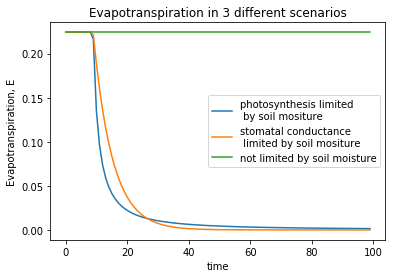

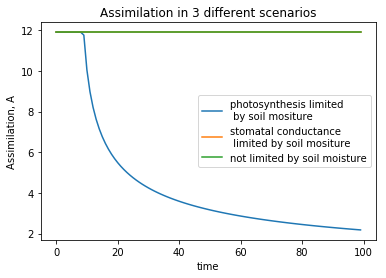

In [203]:
# max no. of time steps
tmax = 100

# create an array filled with constant A the same size as the S array
A_array_const = [A]*tmax

# create an array filled with constant E the same size as the S array
E_array_const = [E]*tmax

###### Soil water limits stomatal conductance - E has to change with each iteration ######

# creating empty arrays for the variables to be put through the time loop:
time = np.zeros((tmax))
S = np.zeros((tmax))
# multiplication factor:
f_s = np.zeros(tmax)
# have to make an empty array of E, as E has to be fed back into the for loop of changing S
E_lim_gs = np.zeros(tmax) # E when soil moisture limits stomatal conductance
dS = np.zeros(tmax) 
A_lim_A = np.zeros(tmax) # A when soil moisture limits photosynthesis
g_s_lim_A = np.zeros(tmax) # gs when soil moisture limits photosynthesis
E_lim_A = np.zeros(tmax) # E when soil moisture limits photosynthesis
dt = 1 # time step

# initial conditions:
t = 0
time[t] = 0
S[t] = S_0
f_s[t] = 1
E_lim_gs[t] = E
dS[t] = dt*(P-E)
E_lim_A[t] = E
A_lim_A[t] = A
g_s_lim_A[t] = g_s

# first for loop is to simulate S, E, A and gs in the scenario of soil moisture limiting stomatal conductance
for t in range(0,tmax-1):
    dS[t] = dt*(P-E_lim_gs[t])
    S[t+1] = S[t]+dS[t]
    time[t+1] = time[t]+dt

    if(S[t+1]>S_m):
        S[t+1] = S_m    
    else:
        S[t+1]=S[t+1]
    
    if S[t+1]>S_c:
        f_s[t+1] = 1
    elif S[t+1]<S_w:
        f_s[t+1] = 0
    else:
        f_s[t+1] = (S[t+1]-S_w)/(S_c-S_w)
        
    # soil moisutre limits stomatal conductance - only E is changed
    E_lim_gs[t+1] = 1.5552*g_s*f_s[t+1]*(e_s-e_a)
    
# second for loop is to simulate S, E, A and gs in the scenario of soil moisture limiting photosynthesis
for t in range(0,tmax-1):
    dS[t] = dt*(P-E_lim_A[t])
    S[t+1] = S[t]+dS[t]
    time[t+1] = time[t]+dt

    if(S[t+1]>S_m):
        S[t+1] = S_m    
    else:
        S[t+1]=S[t+1]
    
    if S[t+1]>S_c:
        f_s[t+1] = 1
    elif S[t+1]<S_w:
        f_s[t+1] = 0
    else:
        f_s[t+1] = (S[t+1]-S_w)/(S_c-S_w)    
    
    # soil moisture limits photosynthesis - both E and A change
    A_lim_A[t+1] = f_s[t+1]*A  
    g_s_lim_A[t+1] = m*(f_s[t+1]*A_lim_A[t+1]/(h*C_a))+b    
    E_lim_A[t+1] = 1.5552*g_s_lim_A[t+1]*f_s[t+1]*(e_s-e_a)

# soil moisture limits gs - does not change A
A_lim_gs = A_array_const
    
plt.plot(E_lim_A, label="photosynthesis limited \n by soil mositure")
plt.plot(E_lim_gs, label="stomatal conductance \n limited by soil mositure")
plt.plot(E_array_const, label="not limited by soil moisture")
plt.legend()
plt.xlabel("time")
plt.ylabel("Evapotranspiration, E")
plt.title("Evapotranspiration in 3 different scenarios")
plt.show()

plt.plot(A_lim_A, label="photosynthesis limited \n by soil mositure")
plt.plot(A_lim_gs, label="stomatal conductance \n limited by soil mositure")
plt.plot(A_array_const, label="not limited by soil moisture")
plt.legend()
plt.xlabel("time")
plt.ylabel("Assimilation, A")
plt.title("Assimilation in 3 different scenarios")
plt.show()


Simulate the development of the biospheric states and fluxes over one year with daily time step.

Output the mean carbon uptake as well as total evapotranspiration and plot the time courses of A, E, gs, and S. 

In [135]:
# make d an array from 1 to 365:
d_array = np.arange(1,365,1)

# calculating top of the atmosphere radiatin R_g

d_r = 1+0.033*np.cos(2*np.pi*(d_array/n_day))
d_d = 0.409*np.sin(2*np.pi*(d_array/n_day)-1.39)
w = np.arccos(-np.tan(lat)*np.tan(d_d))

R_g = 2.2*(1367/(2*np.pi))*d_r*(w*np.sin(lat)*np.sin(d_d)+np.cos(lat)*np.cos(d_d)*np.sin(w))

# temperature:
T = (R_g/(0.25*2.2*1367))*30-5

# saturated vapour pressure:
e_s = 0.6108*np.exp(17.270*T/(T+237.3))

# absolute humidity:
e_a = 0.7*e_s

# relative humidity:
h = e_a/e_s

#### stochastic rain #####

# 1. sample a uniform random number between 0 and 1:
rand_num = np.random.rand(len(d_array))

# 2. if the number is greater than x = 1 - 0.5*(np.cos(2*np.pi*d/n_day)+1)

#create empty arrays:
x = np.zeros(len(d_array))
#rand_num = np.zeros(len(d_array))
rand_num_2 = np.zeros(len(d_array))
P = np.zeros(len(d_array))

#initial values:
#i = 0
#x[i] = 1 - 0.5*(np.cos(0)+1)
# P[i] = 

for i in range(0,len(d_array)-1):

    x[i] = 1 - 0.5*(np.cos(2*np.pi*d_array[i]/n_day)+1)

    if rand_num[i] > x[i]:
        rand_num_2 = np.random.rand()
        P[i] = rand_num_2*5
    else:
        P[i] = 0
        


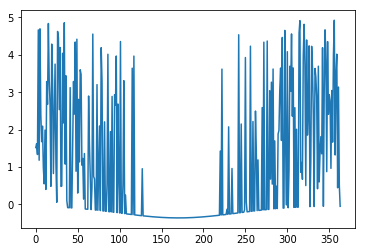

In [242]:
# leaf respiration:
R_d = c_rd*beta*np.exp(E_rd*(T-25)/(298*R*(T+273)))

# assimilation:
A = alpha*beta*R_g/(alpha*R_g+beta)-R_d

# stomatal conductance:
g_s = m*(A/(h*C_a))+b

# transpiration:
E = 1.5552*g_s*(e_s-e_a)

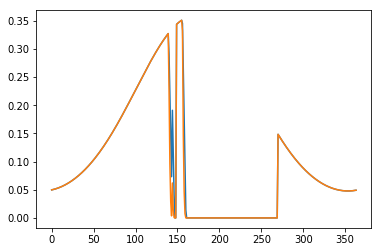

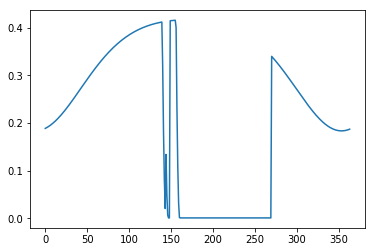

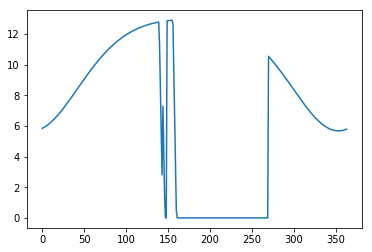

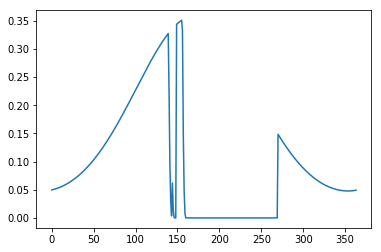

In [163]:
###### soil moisture ######
# creating empty arrays for the variables to be put through the time loop:
S = np.zeros(len(d_array))

# multiplication factor:
f_s = np.zeros(len(d_array))

# have to make an empty array of E, as E has to be fed back into the for loop of changing S
E_lim_gs = np.zeros(len(d_array))
dS = np.zeros(len(d_array))
A_lim_A = np.zeros(len(d_array))
g_s_lim_A = np.zeros(len(d_array))
E_lim_A = np.zeros(len(d_array))

# initial conditions:
t = 0
S[t] = S_0
#time[t] = 0
f_s[t] = 1
dt = 1 #changing time step is important - increasing time step leads to dries soil consitions. at dt=0.1 the soil moisture always exceeds S_c
E_lim_gs[t] = E[0]
dS[t] = dt*(P[0]-E[0])
E_lim_A[t] = E[0]
A_lim_A[t] = A[0]
g_s_lim_A[t] = g_s[0]

for t in range(0,len(d_array)-1,dt):
    dS[t] = dt*(P[t]-E[t])
    S[t+1] = S[t]+dS[t]
    
    if(S[t+1]>S_m):
        S[t+1] = S_m    
    else:
        S[t+1]=S[t+1]
    
    if S[t+1]>S_c:
        f_s[t+1] = 1
    elif S[t+1]<S_w:
        f_s[t+1] = 0
    else:
        f_s[t+1] = (S[t+1]-S_w)/(S_c-S_w)
        
    # soil moisutre limits stomatal conductance - only E is changed
    E_lim_gs[t+1] = 1.5552*g_s[t+1]*f_s[t+1]*(e_s[t+1]-e_a[t+1])
    
    # soil moisture limites photosynthesis - both E and A change
    A_lim_A[t+1] = f_s[t+1]*A[t+1]
    g_s_lim_A[t+1] = m*(f_s[t+1]*A_lim_A[t+1]/(h[t+1]*C_a))+b    
    E_lim_A[t+1] = 1.5552*g_s_lim_A[t+1]*f_s[t+1]*(e_s[t+1]-e_a[t+1])

plt.show()
plt.plot(E_lim_gs)
plt.plot(E_lim_A)
plt.show()
plt.plot(g_s_lim_A)
plt.show()
plt.plot(A_lim_A)
plt.show()
plt.plot(E_lim_A)


In [21]:
# make d an array from 1 to 365 - for the whole year:
d_array = np.arange(1,365,1)

# max no. of time steps = number of elements in d_array
tmax = len(d_array)

# calculating top of the atmosphere radiatin R_g

d_r = 1+0.033*np.cos(2*np.pi*(d_array/n_day))
d_d = 0.409*np.sin(2*np.pi*(d_array/n_day)-1.39)
w = np.arccos(-np.tan(lat)*np.tan(d_d))

R_g = 2.2*(1367/(2*np.pi))*d_r*(w*np.sin(lat)*np.sin(d_d)+np.cos(lat)*np.cos(d_d)*np.sin(w))

# temperature:
T = (R_g/(0.25*2.2*1367))*30-5

# saturated vapour pressure:
e_s = 0.6108*np.exp(17.270*T/(T+237.3))

# absolute humidity:
e_a = 0.7*e_s

# relative humidity:
h = e_a/e_s

#### stochastic rain #####

# 1. sample a uniform random number between 0 and 1:
rand_num = np.random.rand(len(d_array))

# 2. if the number is greater than x = 1 - 0.5*(np.cos(2*np.pi*d/n_day)+1)

#create empty arrays:
x = np.zeros(len(d_array))
rand_num_2 = np.zeros(len(d_array))
P = np.zeros(len(d_array))

for i in range(0,len(d_array)-1):

    x[i] = 1 - 0.5*(np.cos(2*np.pi*d_array[i]/n_day)+1)

    if rand_num[i] > x[i]:
        rand_num_2 = np.random.rand()
        P[i] = rand_num_2*5
    else:
        P[i] = 0
        

Text(0,0.5,'Precipitation (mm/day)')

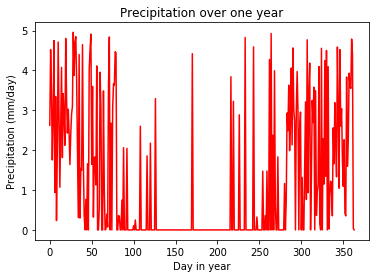

In [45]:
# leaf respiration:
R_d = c_rd*beta*np.exp(E_rd*(T-25)/(298*R*(T+273)))

# assimilation:
A = alpha*beta*R_g/(alpha*R_g+beta)-R_d

# stomatal conductance:
g_s = m*(A/(h*C_a))+b

# transpiration:
E = 1.5552*g_s*(e_s-e_a)

plt.plot(P, color="red")
plt.title("Precipitation over one year")
plt.xlabel("Day in year")
plt.ylabel("Precipitation (mm/day)")

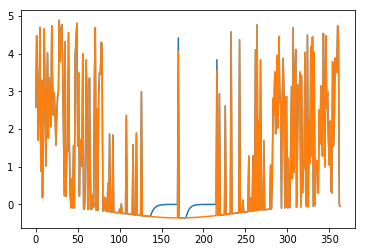

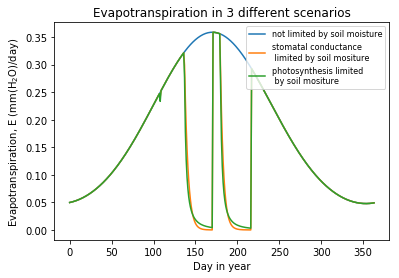

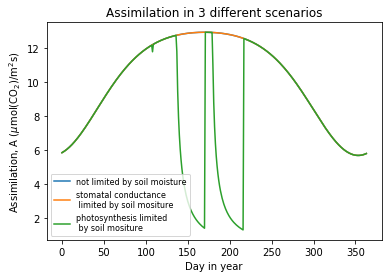

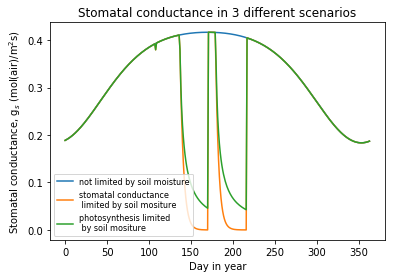

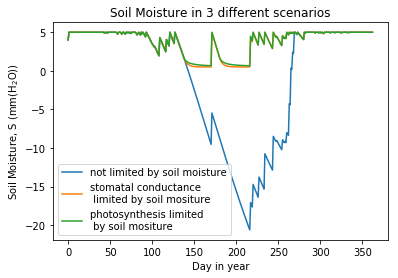

In [43]:
###### Soil water limits stomatal conductance - E has to change with each iteration ######

# creating empty arrays for the variables to be put through the time loop:
time = np.zeros((tmax))
S = np.zeros((tmax))
# multiplication factor:
f_s = np.zeros(tmax)
# have to make an empty array of E, as E has to be fed back into the for loop of changing S
E_lim_gs = np.zeros(tmax)
dS = np.zeros(tmax)
A_lim_A = np.zeros(tmax)
g_s_lim_A = np.zeros(tmax)
E_lim_A = np.zeros(tmax)
g_s_lim_gs = np.zeros(tmax)
dt = 1

# initial conditions:
t = 0
time[t] = 0
S[t] = S_0 # initial soil moisture
f_s[t] = 1
dS[t] = dt*(P[0]-E[0]) # the step S takes with each iteration
g_s_lim_gs[t] = g_s[0] # gs when soil moisture limits stomatal conductance
E_lim_gs[t] = E[0] # E when soil moisture limits stomatal conductance
E_lim_A[t] = E[0] # E when soil moisture limits photosynthesis
A_lim_A[t] = A[0] # A when soil moisture limits photosynthesis
g_s_lim_A[t] = g_s[0] # gs when soil moisture limits photosynthesis

# creating empty arrays for soil moisutre under the different scenarios, so that soil moisture can be plotted for each
S_no_lim = [] 
S_lim_gs = []
S_lim_A = []

# first for loop is to simulate S in the scenario of soil moisture not limiting
for t in range(0,tmax-1):
    dS[t] = dt*(P[t]-E[t])
    S[t+1] = S[t]+dS[t]
    time[t+1] = time[t]+dt
    
    if(S[t+1]>S_m):
        S[t+1] = S_m    
    else:
        S[t+1]=S[t+1]
    
    if S[t+1]>S_c:
        f_s[t+1] = 1
    elif S[t+1]<S_w:
        f_s[t+1] = 0
    else:
        f_s[t+1] = (S[t+1]-S_w)/(S_c-S_w)
        
    S_no_lim.append(S[t])

# second for loop is to simulate S, E, A and gs in the scenario of soil moisture limiting stomatal conductance
for t in range(0,tmax-1):
    dS[t] = dt*(P[t]-E_lim_gs[t])
    S[t+1] = S[t]+dS[t]
    time[t+1] = time[t]+dt

    if(S[t+1]>S_m):
        S[t+1] = S_m    
    else:
        S[t+1]=S[t+1]
    
    if S[t+1]>S_c:
        f_s[t+1] = 1
    elif S[t+1]<S_w:
        f_s[t+1] = 0
    else:
        f_s[t+1] = (S[t+1]-S_w)/(S_c-S_w)
        
    S_lim_gs.append(S[t])
        
    # soil moisutre limits stomatal conductance - only E is changed
    g_s_lim_gs[t+1] = g_s[t+1]*f_s[t+1]
    E_lim_gs[t+1] = 1.5552*g_s_lim_gs[t+1]*(e_s[t+1]-e_a[t+1])
plt.plot(P-E_lim_gs)
plt.plot(P-E)

plt.show()
# third for loop is to simulate S, E, A and gs in the scenario of soil moisture limiting photosynthesis
for t in range(0,tmax-1):
    dS[t] = dt*(P[t]-E_lim_A[t])
    S[t+1] = S[t]+dS[t]
    time[t+1] = time[t]+dt

    if(S[t+1]>S_m):
        S[t+1] = S_m    
    else:
        S[t+1]=S[t+1]
    
    if S[t+1]>S_c:
        f_s[t+1] = 1
    elif S[t+1]<S_w:
        f_s[t+1] = 0
    else:
        f_s[t+1] = (S[t+1]-S_w)/(S_c-S_w)    
    
    S_lim_A.append(S[t])

    # soil moisture limits photosynthesis - both E and A change
    A_lim_A[t+1] = f_s[t+1]*A[t+1]  
    g_s_lim_A[t+1] = m*(A_lim_A[t+1]/(h[t+1]*C_a))+b    
    E_lim_A[t+1] = 1.5552*g_s_lim_A[t+1]*f_s[t+1]*(e_s[t+1]-e_a[t+1])

# soil moisture limits gs - does not change A
A_lim_gs = A
    
plt.plot(E, label="not limited by soil moisture")
plt.plot(E_lim_gs, label="stomatal conductance \n limited by soil mositure")
plt.plot(E_lim_A, label="photosynthesis limited \n by soil mositure")
plt.legend(prop={'size': 8})
plt.xlabel("Day in year")
plt.ylabel("Evapotranspiration, E (mm(H$_2$O)/day)")
plt.title("Evapotranspiration in 3 different scenarios")
plt.show()

plt.plot(A, label="not limited by soil moisture")
plt.plot(A_lim_gs, label="stomatal conductance \n limited by soil mositure")
plt.plot(A_lim_A, label="photosynthesis limited \n by soil mositure")
plt.legend(loc='lower left', prop={'size': 8})
plt.xlabel("Day in year")
plt.ylabel("Assimilation, A ($\mu$mol(CO$_2$)/m$^2$s)")
plt.title("Assimilation in 3 different scenarios")
plt.show()

plt.plot(g_s, label="not limited by soil moisture")
plt.plot(g_s_lim_gs, label="stomatal conductance \n limited by soil mositure")
plt.plot(g_s_lim_A, label="photosynthesis limited \n by soil mositure")
plt.legend(loc='lower left', prop={'size': 8})
plt.xlabel("Day in year")
plt.ylabel("Stomatal conductance, g$_s$ (mol(air)/m$^2$s)")
plt.title("Stomatal conductance in 3 different scenarios")
plt.show()

plt.plot(S_no_lim, label="not limited by soil moisture")
plt.plot(S_lim_gs, label="stomatal conductance \n limited by soil mositure")
plt.plot(S_lim_A, label="photosynthesis limited \n by soil mositure")
plt.legend()
plt.xlabel("Day in year")
plt.ylabel("Soil Moisture, S (mm(H$_2$O))")
plt.title("Soil Moisture in 3 different scenarios")
plt.show()